# Multivariate regression and feature normalisation


## Prerequisites
- [Gradient based optimisation](https://github.com/AI-Core/Strong-ML-Foundations/blob/master/Gradient%20based%20optimisation.ipynb)

## Learning objectives
- Understand
    - how regression extends to the case where an example has more than one feature (monovariate->multivariate)
    - how to implement feature normalisation and why it is necessary
    - how to add polynomial features to a monovariate dataset and implement multivariate regression from scratch
    - that 

- build on your Python skills




## Before we begin, let's just remind ourselves of some notation that we are going to see all over this notebook, and throughout the rest of the course.

![](images/in.jpg)

## Intro - From monovariate to multivariate regression

### Input examples with multiple features

Let's quickly remind ourselves how making predications for examples with a single feature works:
1. the weight is a parameter of our model that controls how much the single feature affects the output

In the case where our input examples have more than 1 feature, we proceed in a similar way, except for the fact that we will now have multiple model weights. Each of these weights controls the influence of the corresponding feature on the predicted model output. 

So
- if a particular feature increasing usually correlates with an increase in the label, then the corresponding model weight should be **positive**. 
- if a particular feature decreasing usually correlates with a decrease in the label, then the corresponding model weight should be **negative**. 
- if a particular feature changing usually correlates with a negligible change in the label, then the corresponding model weight should be **negligible** (near zero).

### Adding our own features to an example

In the previous notebooks, we have trained models to fit input-output relationships which are linear (straight lines). Because our models were linear models, they were able to fit this linear input-output relationships. But if the input-output relationship of the data was not linear, then these models would not be able to fit that relationship.

Another case where we might want to perform multivariate regression is where we want to add our own features to an example which currently only has a single feature. We might do this because we believe that the output label might be dependent on not just the feature available, but perhaps it's square value or another arbitrary transformation of it. 

For example imagine we have a dataset of the width of square floor-plan houses and we want to predict house price. You can imagine that the house price might be more likely to depend on the floor area rather than the square room width, and as such you may choose to add a quadratic term to your model by adding the square of the width as a feature to each example.

Let's create some data where the outputs are not a linear function of the input.

X: [ 0.19572298  0.95762437 -0.80822736 -0.52927212 -0.17334853  0.99496808
 -0.72513225  0.86512141 -0.40769677  0.28316488  0.95148516  0.46897806
 -0.20663458  0.7835636   0.77776071  0.87431173  0.42792727  0.73994518
 -0.32899447 -0.73024661] 

Y: [-0.32673379 -1.80800289  2.21473739  0.9252005   0.07480617 -1.96304874
  1.75794293 -1.47092045  0.55408065 -0.40588025 -1.78359738 -0.60970416
  0.12764314 -1.22409356 -1.20817393 -1.5015741  -0.55813494 -1.10942021
  0.36266106  1.78413954] 

Ground truth coefficients: [-0.14387015 -1.04957786  0.92491015 -1.71628602] 



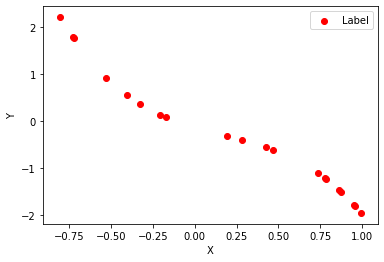

In [2]:
import numpy as np
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from utils import sample_polynomial_data, visualise_regression_data

m = 20 # how many examples do we want?
order = 3 # how many powers do we want to raise our input data to?
X, Y, ground_truth_coeffs = sample_polynomial_data(m, order)
print('X:',X, '\n')
print('Y:',Y, '\n')
print('Ground truth coefficients:', ground_truth_coeffs, '\n')
visualise_regression_data(X, Y)

Let's try to fit this data with a linear model.

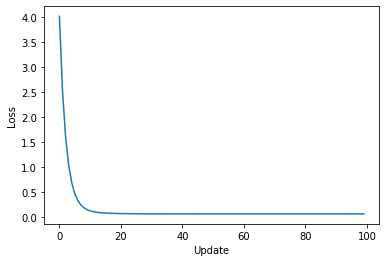

TypeError: 'numpy.ndarray' object is not callable

In [4]:
# THIS IS ALL CODE WE'VE ALREADY COVERED, JUST RUN THIS CELL
class LinearHypothesis:
    def __init__(self):
        self.b = np.random.randn()
        self.w = np.random.randn()
        
    def __call__(self, X): #input is of shape (n_datapoints, n_vars)
        y_hat = self.w * X + self.b # linear hypothesis
        return y_hat # output is of shape (n_datapoints, 1)
    
    def update_params(self, new_w, new_b):
        self.w = new_w
        self.b = new_b
        
    def calc_deriv(self, X, y_hat, labels): 
        """calculates the gradient assuming that we are using mean squared error loss"""
        diffs = y_hat - labels ## calculate error
        dLdw = 2 * np.mean(diffs * X) ## calculate gradient of MSE loss with respect to model weights
        dLdb = 2 * np.mean(diffs) ## calculate gradient of MSE loss with respect to model bias
        return dLdw, dLdb
    
num_epochs = 100
learning_rate = 0.1
H = LinearHypothesis() ## instantiate linear hypothesis model model

def train(num_epochs, X, Y, H):
    losses = []
    for e in range(num_epochs): # for this many complete runs through the dataset
        y_hat = H(X) # make predictions
        # print(X.shape)
        # print(y_hat.shape)
        # print(Y.shape)
        loss = np.mean((y_hat - Y)**2) ## compute loss
        losses.append(loss)
        dLdw, dLdb = H.calc_deriv(X, y_hat, Y) # calculate gradient of current loss with respect to model parameters
        new_w = H.w - learning_rate * dLdw # compute new model weight using gradient descent update rule
        new_b = H.b - learning_rate * dLdb # compute new model bias using gradient descent update rule
        H.update_params(new_w, new_b) # update model weight and bias
#     print(f'THE MODEL DIDNT CONVERGE IN {num_epochs} EPOCHS')
    plt.plot(losses)
    plt.ylabel('Loss')
    plt.xlabel('Update')
    plt.show()
train(num_epochs, X, Y, H) # train model and plot cost curve
visualise_regression_data(X, Y, H(X)) # plot predictions and true data

The model's parameterisation converges to an *optimal* value, where the loss is minimal. But the model does an awful job of representing the relationship between the features (X) and labels (Y) of the dataset. 

If by chance the data that you have created is actually fit reasonably well by the linear model, just run the first cell again to generate some more wavy data so that you can see a linear model having a hard time trying to fit it.


## Modelling more advanced functions

We can make more complex models by assuming that they should contain more, different mathematical terms. For example, instead of our model just having a term for $x$, it could also have a term for $x^2$, $x^3$, and so on (that is, it could include higher order terms). (We could make all kinds of models by including any kind of mathematical terms such as trigonometric terms, exponential terms, gaussian terms etc)

Simple linear model: $y = b + w_1x_1$

Higher order polynomial model: $y = b + w_1x + w_2x^2 + w_3x^3$

To make this more complex model, we could do one of two things:
- keep a single input, $x$, to the model and have the model raise it to several powers when it computes the hypothesis.
    * Every time we process an input, we need to raise it to those powers. This will make our model slower.
- augment the dataset to include these polynomial terms, and then have the model just make a linear combination of those to form a prediction.
    * We don't have to raise the input to any power when we make a prediction, this is all done as preprocessing.
    * This is the method that we will use.
    

Our X variable looks like this now since we have multiple input features

![title](images/X_matrix.jpg)
    
We will train these more complex polynomial models to learn to perform the same task as we did previously.
    
We call this multi-variate linear regression:
- *Multi-variate* - our model now is finding coefficients for multiple input variables (rather than just one like we did previously, that was mono-variate linear regression)
- linear - out output prediction is still a linear function (weighted combination) of each example's input features. (This would not be true if our model only took the original input and then raised it to each power or performed some other transformation on it, rather than performing the augmentation during data preprocessing)
- regression - we are trying to predict a continuous output

Our weights become a vector as opposed to a single value. Each weight represents how much the corresponding feature of each example input should contribute to the prediction. There are `N` features in each example (different powers of the original input if we've augmented our dataset

![title](images/w_vector.jpg)

The weights variable (w) becomes a row vector so we need to transpose it when we multiply it by the X matrix

![title](images/vector_linear_regression.jpg)

Our gradient calculation changes slightly to account for the fact that we have more than one weight (the `j` index appears in the equation to refer to the index of the weight which we are computing the gradient with respect to).

![title](images/NN1_multi_grad_calc.JPG)

Lets try fitting more complex curves than just a straight line by using a polynomial model for multivariate linear regression. 

Change the `__call__` and `calc_deriv` functions of the class below so it works for multiple input variables.

Also complete the create_polynomial_data function to return a copy of the original dataset with extra features which are the orginal x feature raised to higher powers.

In [6]:
class MultiVariableLinearHypothesis:
    def __init__(self, n_features):
        self.n_features = n_features
        self.b = np.random.randn() ## initialise bias
        self.w = np.random.randn(n_features) ## initialise weights
        
    def __call__(self, X): # what happens when we call our model, input is of shape (n_examples, n_features)
        y_hat = np.matmul(X, self.w) + self.b ## make prediction, now using vector of weights rather than a single value
        return y_hat # output is of shape (n_examples, 1)
    
    def update_params(self, new_w, new_b):
        self.w = new_w
        self.b = new_b
        
    def calc_deriv(self, X, y_hat, labels):
        m = len(X)
        diffs = y_hat -labels
        dLdw = 2 / m * np.matmul(X.T, diffs) ## calculate 
        dLdb = 2 * np.sum(diffs) / m
        return dLdw, dLdb

def create_polynomial_inputs(X, order=3):
    new_dataset = np.array([np.power(X, i) for i in range(1, order + 1)]).T ## add powers of the original feature to the design matrix
    return new_dataset # new_dataset should be shape [m, order]

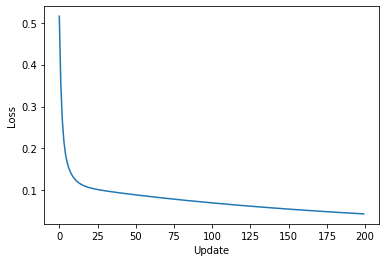

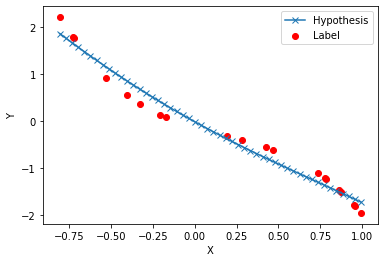

In [7]:
num_epochs = 200
learning_rate = 0.1
highest_order_power = 4

polynomial_augmented_inputs = create_polynomial_inputs(X, highest_order_power) ## need normalization to put higher coefficient variables on the same order of magnitude as the others
H = MultiVariableLinearHypothesis(n_features=highest_order_power) ## initialise multivariate regression model

def vis_H(X):
    poly_X = create_polynomial_inputs(X, highest_order_power)
    return H(poly_X)

train(num_epochs, polynomial_augmented_inputs, Y, H) ## train model
visualise_regression_data(X, Y, vis_H)

## Data Normalization

Let's try to train a model which has an $x^3$ term, $x^2$ term, and an $x$ term.

In [ ]:
learning_rate = 0.1
highest_order_power = 3
# num_epochs = 10
m = 50

X, Y, ground_truth_coeffs = sample_polynomial_data(m, 1, _range=10)
new_dataset = create_polynomial_inputs(X, highest_order_power)

H = MultiVariableLinearHypothesis(n_features=highest_order_power)

print('Training')
train(num_epochs, new_dataset, Y, H) # train model and plot cost curve
print('Weights after training:', H.w)
print('True weights:', ground_truth_coeffs[1:])
plot_h_vs_y(X, H(new_dataset), Y)

This doesn't converge. We might even get NaN (Not a Number) values for our weights.
Maybe the learning rate is too high and it's diverging? Let's try fixing that.

In [ ]:
learning_rate = 0.000001

H = MultiVariableLinearHypothesis(n_features=highest_order_power)

train(num_epochs, new_dataset, Y, H) # train model and plot cost curve
print('Weights after training:', H.w)
print('True weights:', ground_truth_coeffs[1:])
plot_h_vs_y(X, H(new_dataset), Y)

Now this seems to not diverge, but the parameters are still wrong. All of the weights except for the $x$ term should go to zero, because our data generating function has no $x^2$ or $x^3$ term.

Maybe our model doesn't have the capacity to represent the input-output relationship between our inputs and outputs? But this can't be true - we know that our model can represent linear functions because it has a linear ($x$) term. In fact, it has way more capacity than it needs.

Maybe if we train the model for longer it will converge to the correct parameterisation. But we can't increase the learning rate to implement this because otherwise it will fail to converge as we saw in the cell above this one. We could increase the number of epochs (runs through the dataset), but we managed to train a similar model to fit a more complex function before, and all we've changed is the range of our input features (hint)! Surely there's something else happening, right?

### What's happening?

Note that the input features of this new dataset which I created in this example range from -10 to +10 (and our model fails to converge), rather than the default input feature range -1 to +1 (that we managed to fit earlier). 

![](images/grad-prop.jpg)

The above equation shows us that the gradients of each weight are proportional to the feature which they control the contribution of.

![](images/orders.jpg)

This is what causes the problem. If we raise any number with magnitude < 1 to any positive power it will always get smaller. But if we raise any number with magnitude > 1 to any positive power it will always get exponentially larger. Now that the magnitude of our features can be larger than 1, the squared, cubed etc features can be much larger. The derivative of our cost w.r.t a particular weight is proportional to the value of that feature, the derivatives for the weight will be extremely high. If our learning rate is not low enough, this will lead to huge steps for that weight. These large steps will probably jump right over the optimal parameter value to an even worse one where the gradient is even higher! This cycle continues until our gradients have *exploded* to NaN (a number too large to represent).

We tried to tackle this problem by reducing the learning rate so that our models parameters would converge along the axis of the weight which has the largest gradients. But this might be the only weight for which the learning rate is too large, and so by reducing it we prevent our model making fast progress for the other parameters - so learning takes more updates than it needs to.

We could try having individual learning rates for each of our model parameters, but then we'd need to tune each of these. This will become impractical when we begin to use models with more than several parameters (the neural networks that we will use later might have millions). 

Instead, we will use a technique called **feature normalisation**.

### Let's visualise why we need feature normalisation

The code below opens a visualisation of a loss surface for a model with 2 parameters. As usual, each of these 2 parameters control how much an associated input affect the prediction, and hence the loss. In this example, I have augmented a dataset of inputs so that it only includes those input features squared and cubed.

I.E. original features, $X = \begin{bmatrix} x_{(1)} \\ \vdots \\ x_{(m)} \end{bmatrix}$, augmented features $X' = \begin{bmatrix} x_{(1)}^2 \ x_{(1)}^3 \\ \vdots \ \ \ \ \vdots \\ x_{(m)}^2 \ x_{(m)}^3 \end{bmatrix}$.

Below, our original input features vary from -5 to +5. In the augmented dataset, the features that were squared now range from 0 to 25 ($5^2$), and the features that were cubed now range from 0 to 125 ($5^3$). 

Run the cell below to visualise how gradient descent trains our model. Don't worry about deciphering the code - it's mainly just stuff for plotting. Change which learning rate you are using by toggling the commented lines before the last block of code. 

This cell crashed my jupyter kernel each time I ran it, so you may need to restart the kernel using the restart button in the control bar at the top of this page.

In [ ]:
%matplotlib
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# true params
a = 0.5
b = 0.5
p = 0.2 # how far around this ground truth should i show?

m = 2 # num examples
r = 5
d = 1
k = 20 # num weights

x_vis = np.linspace(-r, r, m)
x1 = x_vis**2
x2 = x_vis**3

w = np.linspace(a-p, a+p, k)
w1, w2 = np.meshgrid(w, w)

def calc_loss(w1, w2):
    l = []
    for idx in range(len(x_vis)): # for each example
        h =  w1 * x1[idx] + w2 * x2[idx] # make prediction
        y = a * x1[idx] + b * x2[idx] # get true value using actual parameters    
        l.append((h - y)**2)
    l = np.mean(l)
    return l

L = np.zeros((k, k))
for i in range(k): # for each value of weight 1
    for j in range(k): # for each value of weight 2
        L[i][j] = calc_loss(w[i], w[j])

L = np.array(L)
ax.set_xlim(b-p, b+p)
ax.set_ylim(a-p, a+p)
ax.set_zlim(0, L.max())
ax.set_xlabel('Coefficient of $x^2$ term')
ax.set_ylabel('Coefficient of $x^3$ term')
ax.set_zlabel('Loss')

norm = plt.Normalize(L.min(), L.max())
colors = cm.viridis(norm(L))
rcount, ccount, _ = colors.shape

ax.plot([b, b], [a, a], [-20, L.max()], c='#ff822e', label='Optimal parameterisation')

s = ax.plot_surface(w2, w1, L, cmap=cm.coolwarm, rcount=rcount, ccount=ccount, facecolors=colors, shade=False)
s.set_facecolor((0,0,0,0))

ax.legend()

def calc_grad(w1, w2):
    grads = []
    for idx in range(len(x_vis)): # for each example
        h =  w1 * x1[idx] + w2 * x2[idx] # make prediction
        y = a * x1[idx] + b * x2[idx] # get true value using actual parameters    
        x = np.array([x1[idx], x2[idx]])
        x = x.reshape(2, 1)
        diff = np.array(h-y).reshape(1)
        g = np.matmul(x, diff)
        grads.append(g)
    grads = np.array(grads)
    grads = np.mean(grads, axis=0) # rescaled to visualise more easily
    return grads

w1, w2 = [0.68, 0.68] # initial weights

# PLAY AROUND WITH THESE BY UNCOMMENTING THEM ONE AT A TIME (YOU MAY NEED TO RESTART THIS JUPYTER KERNEL AFTER TRYING EACH)
lr = 0.00015 # too large to converge in x^3 direction
lr = 0.00001 # too small to make progress in x^2 direction
lr = 0.00012 # best learning rate


plt.show()

for i in range(30):
    loss = calc_loss(w1, w2)
    w_plot = ax.scatter([w1], [w2], loss, s=100, c='#ff822e')
    g = calc_grad(w1, w2)
    w1u = - lr * g[0]
    w1n = w1 + w1u
    w2u = - lr * g[1]
    w2n = w2 + w2u
    lossn = calc_loss(w1n, w2n)
    ax.plot([w1, w1n], [w2, w2n], [loss, lossn], c='#ff822e')
    w1, w2 = w1n, w2n
    plt.draw()
    plt.pause(.1)

The third learning rate is too large and causes the value of the $x^3$ model weight to diverge, even though the $x^2$ parameter converges.

The second learning rate highlights how progress can be made for all parameters with a low enough learning rate, but this massively increases how many updates are needed for the model to converge and hence could create bottlenecks in how quickly we could train models.

The last learning rate works. I've tuned it by hand so that it is near to the largest value that it can be for the model to still converge. But because the $x^2$ parameter is still updated with the same learning rate, and it's gradients are lower (proportional to $x^2$ rather than $x^3$), the step sizes are smaller and hence progress is slower compared to the $x^3$ parameter.

Lot's of optimisation visualisations misleadingly show the parameters smoothly updating. But this is not what happens in real life. In reality the weights are moved instantly to some new position, as we visualise here.

### What can we do about it?

In order to solve this problem, we must **normalize each of our input features** to put them on the same order of magnitude. 
We can do this by subtracting the minimum then dividing by the range (feature normalisation).

![title](images/normalisation.jpg)

We can alternatively use a similar method called standardisation, where we subtract the mean then divide by the standard deviation.

![](images/standardisation.jpg)

Feature normalisation puts gradients of each different model parameter on the same order of magnitude. This converts loss surfaces that might look like *valleys* into loss surfaces that look like *bowls*. Feature normalisation means that we should be able to make progress with optimisation for all model parameters using the same learning rate.

![](images/bowl.png)

**Note that when we come to deploying our model to make predictions in the real world, we would have to standardise/normalise the input features, using the mean and standard deviation used for normalisation (or min and range for standardisation) during training, before passing them through our model.**

Complete the function below which normalizes each feature in our dataset.

In [5]:
def standardize_data(dataset):
    mean, std = np.mean(dataset, axis=0), np.std(dataset, axis=0) ## get mean and standard deviation of dataset
    standardized_dataset  = (dataset-mean)/std
    return standardized_dataset

Now, without changing the number of epochs that we tried last time, let's try to fit our model to the data. We should be able to increase the learning rate now too.

In [ ]:
learning_rate = 0.01
highest_order_power = 20

X_polynomial_augmented = create_polynomial_inputs(X, highest_order_power) ## create poly inputs
X_normalized = standardize_data(X_polynomial_augmented) ## standardise
H = MultiVariableLinearHypothesis(n_features=highest_order_power) ## init model
print(X_normalized)
train(num_epochs, X_normalized, Y, H) ## train model
plot_h_vs_y(X, H(X_normalized), Y) # plot hypothesis vs labels

## Normalising new examples

If we normalise all of the inputs before training our model on them, then our model will only know how to transform similarly transformed inputs.
That is, we'll need to save these feature means and standard deviations and use them to normalise any new examples that we want our model to make predictions, whether they are for further training, testing or making predictions in the real world.

## Summary
- we can extend the ideas behind monovariate regression to the case where inputs have more than one feature, to perform multi-variate regression
- we can normalise our input features to prevent your model either failing to converge, or taking too long to do so. 
- we need to normalise unseen examples that we want to make predictions on in the real world in the same way that all of our training examples were normalised before being fed to our model during training

## Next steps
- [Bias, variance and generalisation]